In [1]:
import glob
import os
import re
from nltk.tokenize import word_tokenize
import nltk
import tarfile
nltk.download('punkt')
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K
!pip install keras_metrics
import keras_metrics
!pip install transformers
from transformers import BertTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 412.3MB 37kB/s 
     |████████████████████████████████| 3.8MB 59.9MB/s 
     |████████████████████████████████| 512kB 65.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6763cbd241f0dbf8ee5e1086c92fc324fa9f8aa3537849593f020b1d4ea3f30b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorfl

Using TensorFlow backend.


     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 13.8MB/s 
     |████████████████████████████████| 890kB 18.8MB/s 
     |████████████████████████████████| 3.8MB 24.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=14f02723adaab6d4ae34fb9591e18e8b055c555123c379b272a21ad676e880be
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=1g6zN3aoYZKhc9IcqsBg8SWfJwHwayr3j'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('aclImdb_v1.tar.gz')  
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        # !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        # # wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    # !tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")


1g6zN3aoYZKhc9IcqsBg8SWfJwHwayr3j
Dataset already downloaded
Unpacking dataset
Dataset unpacked in aclImdb


In [0]:
positive_sample_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
# positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
# negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text


positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_labels = [1 for x in positive_sample_file_list]
negative_labels = [0 for x in negative_sample_file_list]

# positive_tokenized = [word_tokenize(s) for s in positive_strings]
# negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [0]:
sentences = positive_strings + negative_strings
labels = positive_labels + negative_labels

In [0]:
import pandas as pd
df = pd.DataFrame(
    {'sentences': sentences,
     'sentiment': labels
    })
# df = df.sample(5000)

In [0]:
df.head()

,sentences,sentiment
0,Page 3 is one of those films Madhur Bhandarkar...,1
1,Terrfic film with a slightyly slow start - giv...,1
2,"I went to see Fever Pitch with my Mom, and I c...",1
3,Years ago I did follow a soap on TV. So I was ...,1
4,I loved this movie. I knew it would be chocked...,1


In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
df.head()

,sentences,sentiment
0,"It's 1982, Two years after the Iranian Embassy...",0
1,As a convert into the Church of Jesus Christ o...,1
2,"After a long period in the space, looking for ...",0
3,"Don't get me wrong, Dan Jansen was a great spe...",0
4,"This, and Immoral Tales, both left a bad taste...",0


In [8]:
nltk.download('stopwords')
positive_sample_file_list = glob.glob(os.path.join('aclImdb/test/pos', "*.txt"))
# positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/test/neg', "*.txt"))
# negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_labels = [1 for x in positive_sample_file_list]
negative_labels = [0 for x in negative_sample_file_list]

# positive_tokenized = [word_tokenize(s) for s in positive_strings]
# negative_tokenized = [word_tokenize(s) for s in negative_strings]

sentences = positive_strings + negative_strings
labels = positive_labels + negative_labels

import pandas as pd
df_test = pd.DataFrame(
    {'sentences': sentences,
     'sentiment': labels
    })
df_test = df_test.sample(5000)
df_test = df_test.sample(frac=1).reset_index(drop=True)

test_sentences = df_test.sentences.values
test_labels = df_test.sentiment.values

from nltk.tokenize.treebank import TreebankWordDetokenizer
test_sentences = [word_tokenize(s) for s in test_sentences]

pre_sen = []
for tokens in test_sentences:
  tokens = [w.lower() for w in tokens]
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  pre_sen.append(words)
test_sentences = pre_sen

t_sen = []
for s in test_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))

test_sentences = t_sen

# df_test = pd.DataFrame(
#     {'sentences': test_sentences,
#      'sentiment': test_labels
#     })

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import numpy as np
# msk = np.random.rand(len(df)) < 0.8
# df_train = df[msk]
# df_test = df[~msk]
train_sentences = df.sentences.values
train_labels = df.sentiment.values
# test_sentences = df_test.sentences.values
# test_labels = df_test.sentiment.values

In [0]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
train_sentences = [word_tokenize(s) for s in train_sentences]

pre_sen = []
for tokens in train_sentences:
  tokens = [w.lower() for w in tokens]
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  pre_sen.append(words)
train_sentences = pre_sen

t_sen = []
for s in train_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))

In [0]:
train_sentences = t_sen

In [0]:
train_sentences[0]

'rosenstrasse touching story courage adversity reichdeutch women find jewish husbands locked pending deportation one aristocrat disowned family lena fischer finds among mob general gudarian sister rank privilege merit special consideration service reich female detainee whose husband ostfront learn one horrifying scenes movie guards take wedding band given soldier husband lest think typical german brutishness america today lady bush imperiously ordering arrest gold star mothers mothers us servicemembers killed action presence offencive little regrettably changed years der fuher der fumbler fortunately eight year old daughter ruth escapes capture waiting cold rosenstrasse lena fischer first reluctant take ruth responding way take typically german even lena fisher brother colonel arthur von eschenbach aware opposed holocost cautions lena lena chooses embrace idea american rebelliousness even renaming ruth aryan sounding name helga'

In [0]:
# train_sentences = tf.keras.preprocessing.sequence.pad_sequences(train_sentences, maxlen=128,dtype= object,padding='post', truncating='post', value="")

In [12]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url,trainable = True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:absl:Downloaded https://tfhub.dev/google/elmo/2, Total size: 357.40MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.


In [0]:
def prepare_onehot():
  x_train = np.asarray(train_sentences)
  y_train = np.asarray(keras.utils.to_categorical(train_labels))
  x_test = np.asarray(test_sentences)
  y_test = np.asarray(keras.utils.to_categorical(test_labels))
  return x_train,y_train,x_test,y_test
x_train,y_train,x_test,y_test = prepare_onehot()

In [0]:
x_train.shape

(25000,)

In [14]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)),
                signature="default",
                as_dict=True)["default"]
def create_model():
  input_text = Input(shape=(1,), dtype=tf.string)
  embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
  dense = Dense(1024, activation='relu')(embedding)
  pred = Dense(2, activation='softmax')(dense)
  model = Model(inputs=[input_text], outputs=pred)
  ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='categorical_crossentropy', optimizer=ada, metrics=['accuracy'])
  return model

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [17]:
model = create_model()
history = model.fit(x_train, y_train, epochs=50, batch_size=250,validation_data = (x_test,y_test) )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 25000 samples, validate on 5000 samples
Epoch 1/50
25000/25000 [==============================] - 227s 9ms/step - loss: 0.5005 - accuracy: 0.7560 - val_loss: 0.4464 - val_accuracy: 0.7890
Epoch 2/50
25000/25000 [==============================] - 226s 9ms/step - loss: 0.4209 - accuracy: 0.8099 - val_loss: 0.4198 - val_accuracy: 0.8052
Epoch 3/50
25000/25000 [==============================] - 226s 9ms/step - loss: 0.3996 - accuracy: 0.8192 - val_loss: 0.4089 - val_accuracy: 0.8120
Epoch 4/50
25000/25000 [==============================] - 226s 9ms/step - loss: 0.3869 - accuracy: 0.8271 - val_loss: 0.4001 - val_accuracy: 0.8144
Epoch 5/50
25000/25000 [==============================] - 227s 9ms/step - loss: 0.3807 - accuracy: 0.8298 - val_loss: 0.4077 - val_accuracy: 0.8128
Epoch 6/50
25000/25000 [==============================] - 226s 9ms/step - loss: 0.3724 - accuracy: 0.8340 - val_loss: 0.3935 - val_accuracy: 0.8202
Epoch 7/50
25000/25000 [==============================] - 226s 

In [0]:
model.save_weights('./elmo-model_sent1.h5')
# model.load_weights('./elmo-model_sent1.h5')

In [0]:
predict = model.predict(x_test)

In [0]:
pred = [np.where(t == np.max(t))[0][0] for t in predict]

In [0]:
yr = [np.where(t == np.max(t))[0][0] for t in y_test]

AUC :  0.8214115002322757
accuracy :  0.821
precision :  0.8474936278674596
recall :  0.7882259976293955
F1 :  0.8167860798362333


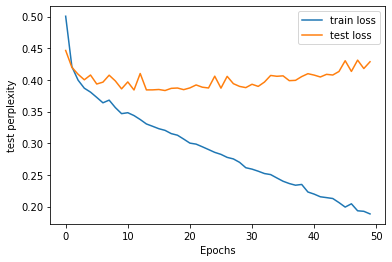

In [21]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])